In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# Black–Scholes Option Pricing & Greeks

## Pricing Formulas (no dividends, continuous compounding)

$$
C = S_0 \, N(d_1) - K e^{-rT} N(d_2),
$$

$$
P = K e^{-rT} N(-d_2) - S_0 \, N(-d_1),
$$
where
$$
d_1 = \frac{\ln\!\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}},
\qquad
d_2 = d_1 - \sigma \sqrt{T}.
$$

---

## Greeks (for calls; puts via parity)

$$
\Delta_{\text{call}} = N(d_1),
$$
$$
\Gamma = \frac{\phi(d_1)}{S_0 \, \sigma \sqrt{T}},
$$
$$
\text{Vega} = S_0 \, \phi(d_1) \, \sqrt{T},
$$
$$
\Theta_{\text{call}} = -\frac{S_0 \, \phi(d_1) \, \sigma}{2 \sqrt{T}} - r K e^{-rT} N(d_2),
$$
$$
\rho_{\text{call}} = K T e^{-rT} N(d_2).
$$

> **Note:** Vega above is per **1.00** change in volatility. Divide by 100 to get “per vol point” (1% vol).

---

## Put Greeks (via put–call parity)

$$
\Delta_{\text{put}} = N(d_1) - 1,
$$
$$
\Theta_{\text{put}} = -\frac{S_0 \, \phi(d_1) \, \sigma}{2 \sqrt{T}} + r K e^{-rT} N(-d_2),
$$
$$
\rho_{\text{put}} = -K T e^{-rT} N(-d_2).
$$

---

## Variable Glossary

- $S_0$: current underlying price  
- $K$: strike price  
- $T$: time to maturity (in years)  
- $r$: risk-free interest rate (continuous compounding)  
- $\sigma$: volatility of returns (annualized)  
- $N(\cdot)$: standard normal cumulative distribution function  
- $\phi(\cdot)$: standard normal probability density function  

---

## Notes

- **With continuous dividend yield $q$**:  
  Replace $S_0$ with $S_0 e^{-qT}$,  
  and in $d_1$ replace $r$ with $r - q$.
- **Put–call parity (no dividends)**:  
  $$
  C - P = S_0 - K e^{-rT}.
  $$


In [2]:
N = norm.cdf

In [3]:
#  d1, d2 computation according to Black-Scholes framework

def d1(K, S0, r, sigm, T):
    return (np.log(S0/K) + (r + (sigm**2) / 2)*T) / (sigm*np.sqrt(T))

In [4]:
def d2(K, S0, r, sigm, T):
    return d1(K, S0, r, sigm, T) - sigm*np.sqrt(T)

In [5]:
def greek_delta(K, S0, r, sigm, T, opt_type):
    if opt_type == "call":
        delt = N(d1(K, S0, r, sigm, T))
    elif opt_type == "put":
        delt = N(d1(K, S0, r, sigm, T)) - 1
    
    return delt

In [6]:
def greek_theta(K, S0, r, sigm, T, opt_type):
    
    first_term = -0.5 * S0 * sigm * np.exp( -0.5 *  (d1(K, S0, r, sigm, T)) **2 ) / ( np.sqrt(2*np.pi*T) ) 

    if opt_type == "call":
        sec_term = - r * K *np.exp(-r*T)*N(d2(K, S0, r, sigm, T))
    elif opt_type == "put":
        sec_term = r * K *np.exp(-r*T)*N(-d2(K, S0, r, sigm, T))
    else: 
        sec_term = 0
        
    return first_term + sec_term

In [7]:
def get_greek_func(greek_name):
    greek_name = greek_name.lower()
    if greek_name == "delta": return greek_delta
    if greek_name == "gamma": return greek_gamma
    if greek_name == "vega":  return greek_vega
    if greek_name == "theta": return greek_theta
    if greek_name == "rho":   return greek_rho
    raise ValueError("greek_name must be one of: delta, gamma, vega, theta, rho")

In [8]:
def delta_3d_surf(delt, S_grid, T_grid, greek_l, opt_type="call"):
    
    # Create 3D figure

    if greek_l == "delta":
        gr_l = r"$\Delta$"
    if greek_l == "theta":
        gr_l = r"$\Theta$"
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(S_grid, T_grid, delt,
                           cmap='viridis', edgecolor='none', alpha=0.9)
    
    # Labels
    ax.set_xlabel('Stock Price S')
    ax.set_ylabel('Time to Maturity T (years)')
    ax.set_zlabel('Delta')
    # Add color bar
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Delta Value')
    
    plt.title(f"{gr_l} Surface of " + f"{opt_type} option")       
    plt.show()

In [9]:
K = 100
r = 0.02
sigm = 0.2


S_vals = np.linspace(60, 140, 60)
T_vals = np.linspace(0.05, 2.0, 60)

S_grid, T_grid = np.meshgrid(S_vals, T_vals)

In [10]:
delt_call = greek_delta(K, S_grid, r, sigm, T_grid, "call")

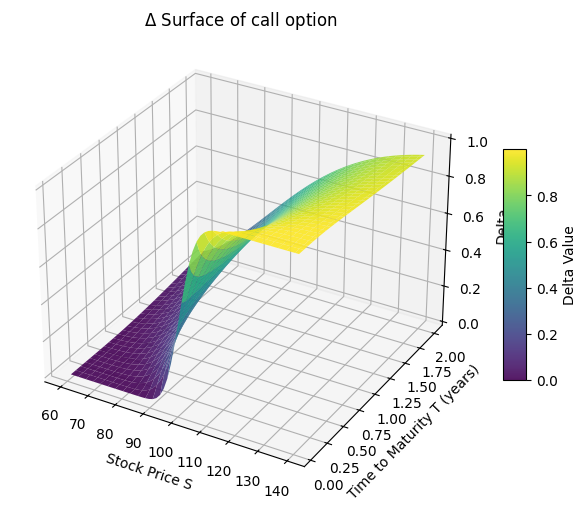

In [11]:
delta_3d_surf(delt_call, S_grid,  T_grid, "delta")

In [12]:
def plot_greek_vs_S(greek_l, K, r, sigm,fixed_time, 
                    spoints, opt_type="call"):
    """
    Plot Greek(S) for several fixed maturities T in years.
    S is shown as a multiple of K .
    """

    if greek_l == "delta":
        gr_l = r"$\Delta$"
    if greek_l == "theta":
        gr_l = r"$\Theta$"

    greek_func = get_greek_func(greek_l)
        
    for i in range(len(fixed_time)):
        delt_points = greek_func(K, st_points, r, sigm, fixed_time[i], opt_type)
        plt.plot(st_points, delt_points, label=f"T={round(fixed_time[i],2) }, years")

    plt.axvline(x=K, color='red', linestyle='--', linewidth=1.5, label='Strike Price')
    plt.xlabel("Stock Price $S$")
    plt.ylabel(fr"{gr_l} ({opt_type})")
    plt.title(fr"{opt_type.capitalize()} {gr_l} vs. Stock Price for Fixed $T$")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
def plot_greek_vs_T(greek_l, K, r, sigm,time_points, 
                    fixed_ST, opt_type="call"):
    """
    Plot Greek(T) for several fixed S.
    """

    if greek_l == "delta":
        gr_l = r"$\Delta$"
    if greek_l == "theta":
        gr_l = r"$\Theta$"

    greek_func = get_greek_func(greek_l)
        
    for i in range(len(fixed_ST)):
        delt_points = greek_func(K, fixed_ST[i], r, sigm, time_points, opt_type)
        plt.plot(time_points, delt_points, label=f"S={round(fixed_ST[i],1) }$")

    
    plt.xlabel("Stock Price $S$")
    plt.ylabel(fr"{gr_l} ({opt_type})")
    plt.title(fr"{opt_type.capitalize()} {gr_l} vs. Time to Maturity T (years) for Fixed S")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
fixed_time = np.linspace(0.05, 2.0, 5)
st_points = np.linspace(60, 140, 50)

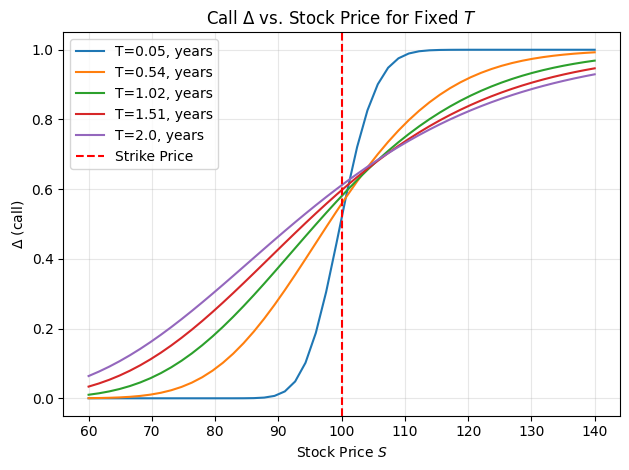

In [14]:
plot_greek_vs_S("delta", K, r, sigm,fixed_time, 
                    st_points, opt_type="call")

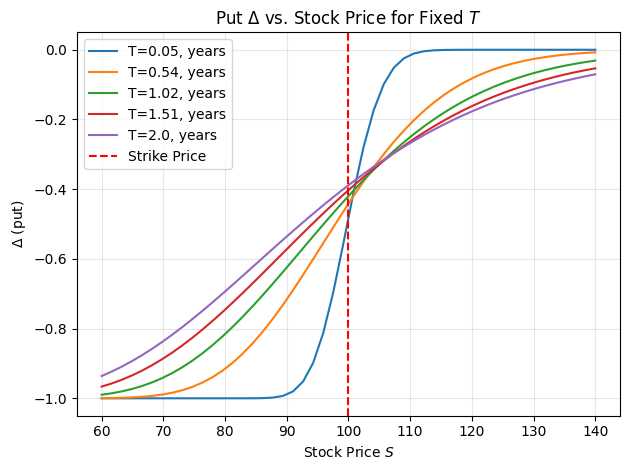

In [15]:
plot_greek_vs_S("delta", K, r, sigm,fixed_time, 
                    st_points, opt_type="put")

In [17]:
fixed_ST = np.linspace(60, 140, 6)
time_points = np.linspace(0.05, 2.0, 20)

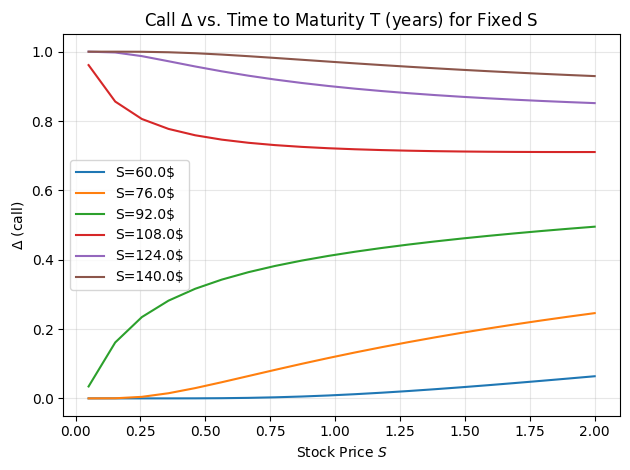

In [18]:
plot_greek_vs_T("delta", K, r, sigm,time_points, fixed_ST, opt_type="call")

In [19]:
theta_call = greek_theta(K, S_grid, r, sigm, T_grid, "call")

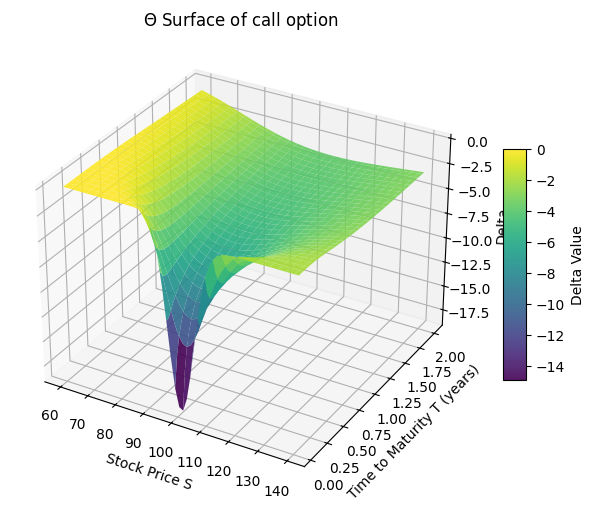

In [20]:
delta_3d_surf(theta_call, S_grid, T_grid, "theta", opt_type="call")

In [21]:
theta_put = greek_theta(K, S_grid, r, sigm, T_grid, "put")

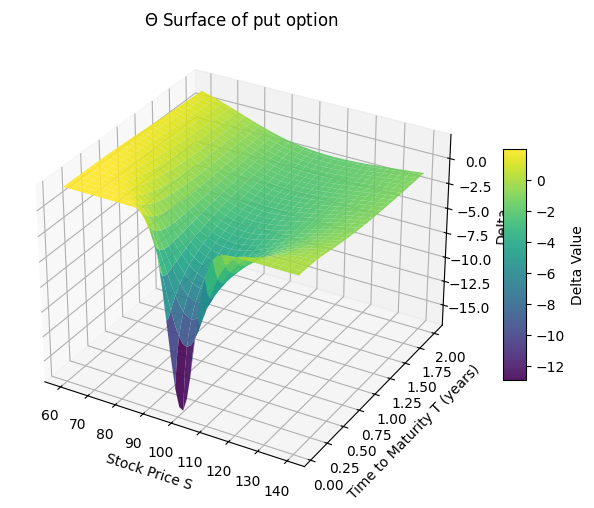

In [22]:
delta_3d_surf(theta_put, S_grid, T_grid, "theta", opt_type="put")

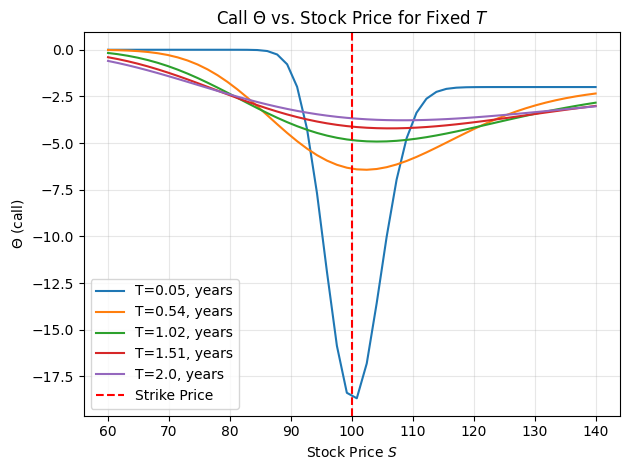

In [23]:
plot_greek_vs_S("theta", K, r, sigm,fixed_time, 
                    st_points, opt_type="call")

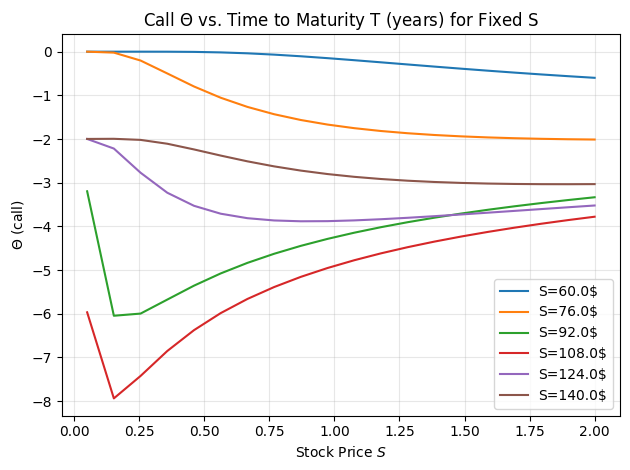

In [24]:
plot_greek_vs_T("theta", K, r, sigm,time_points, fixed_ST, opt_type="call")